In [3]:
from datasets.datasets import SN8Dataset
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

def viz_rgb_image(image):
    raw_im = np.moveaxis(image, 0, -1) # now it is channels last
    raw_im = raw_im/np.max(raw_im)
    plt.imshow(raw_im)
    plt.show()
    
def viz_flood_mask(flood, preimage, postimage):
    combined_mask_cmap = colors.ListedColormap(['black', 'red', 'blue', 'purple', 'yellow'])
    if preimage is not None and postimage is not None:
        fig, axs = plt.subplots(1, 3, figsize=(24,8))
        ax=axs[0]
        ax.set_title("ground truth", fontsize=16)
        ax.imshow(flood,
                  interpolation='nearest', origin='upper',
                  cmap=combined_mask_cmap,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
        fig.suptitle('Flood Ground Truth and Pre-Event Imagery \n (1=non-flood building, 2=flood building, 3=non-flood road, 4=flood road)', fontsize=16)
        ax = axs[1]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        raw_im = np.moveaxis(preimage, 0, -1) # now it is channels last
        raw_im = raw_im/np.max(raw_im)
        ax.imshow(raw_im)
        flood = np.where(flood==0, np.nan, flood)
        ax=axs[1]
        ax.set_title("pre-event image and ground truth", fontsize=16)
        im = ax.imshow(flood,
                  interpolation='nearest', origin='upper',
                  cmap=combined_mask_cmap, alpha=0.6,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax=axs[2]
        ax.set_title("post-event image", fontsize=16)
        raw_im2 = np.moveaxis(postimage, 0, -1) # now it is channels last
        raw_im2 = raw_im2/np.max(raw_im2)
        ax.imshow(raw_im2)
        plt.show()
    else:
        plt.imshow(flood,
                  interpolation='nearest', origin='upper',
                  cmap=combined_mask_cmap,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
        plt.colorbar()
        plt.show()
    
def viz_roadspeed_mask(roadspeed, image=None):
    combined_mask_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red',
                                                'purple', 'orange', 'yellow', 'brown',
                                                'pink'])
    if image is not None:
        fig, axs = plt.subplots(1, 2, figsize=(16,8))
        ax=axs[0]
        ax.imshow(roadspeed, cmap=combined_mask_cmap, interpolation='nearest', origin='upper',
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
        
        fig.suptitle('Road Speed Ground Truth and Pre-Event Imagery', fontsize=16)
        ax = axs[1]
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)

        raw_im = np.moveaxis(image, 0, -1) # now it is channels last
        raw_im = raw_im/np.max(raw_im)
        ax.imshow(raw_im)
        roadspeed = np.where(roadspeed==0, np.nan, roadspeed)
        ax=axs[1]
        im = ax.imshow(roadspeed, cmap=combined_mask_cmap, interpolation='nearest', origin='upper', alpha=0.6,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
        fig.colorbar(im, cax=cax, orientation='vertical')
        plt.show()
    else:
        plt.imshow(roadspeed, cmap=combined_mask_cmap, interpolation='nearest', origin='upper',
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
        plt.colorbar()
        plt.show()

loaded 122 image filepaths
filename:  areas_of_interest/Louisiana-East_Training_Public/PRE-event/105001001A0FFC00_0_13_5.tif


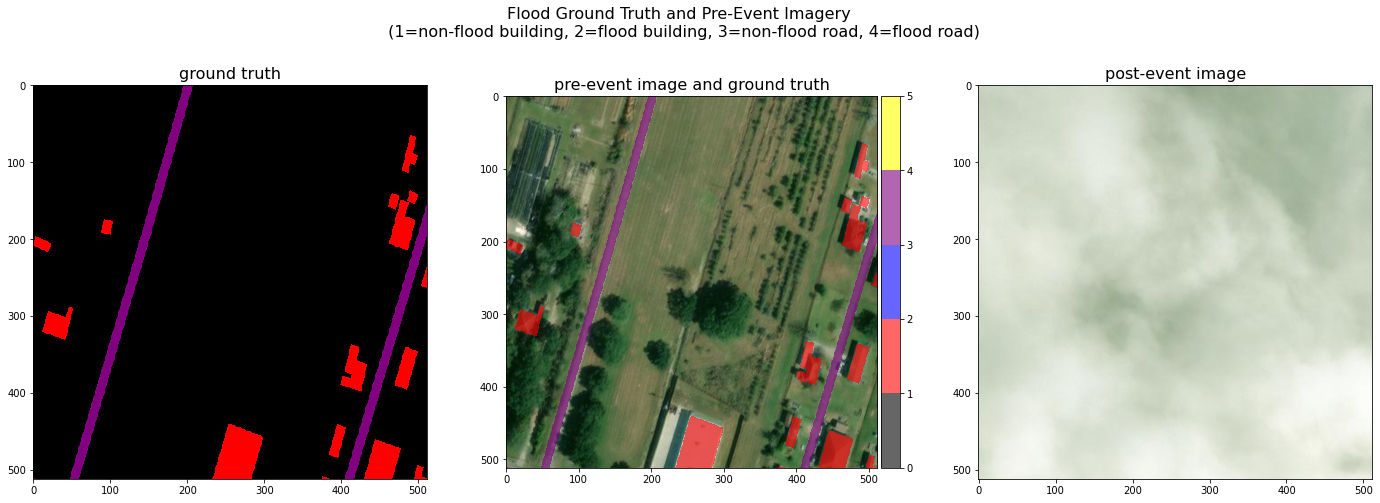

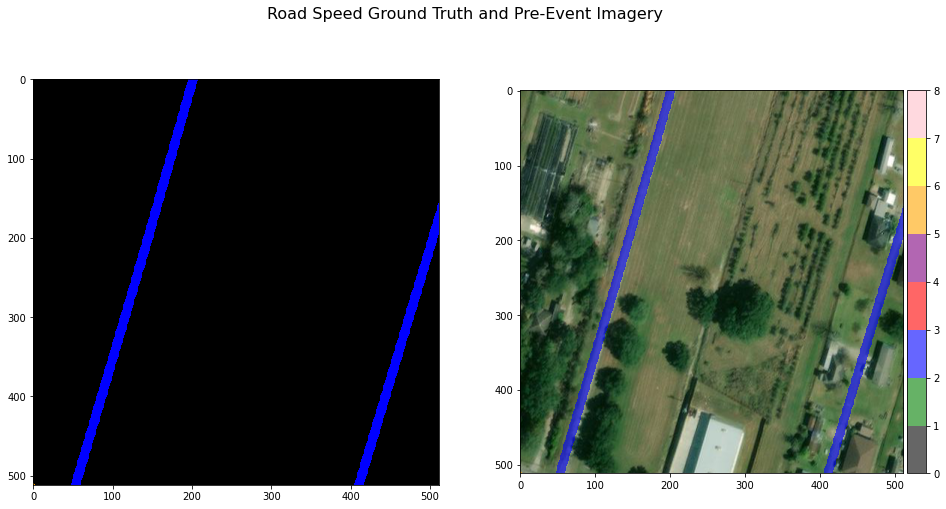

filename:  areas_of_interest/Germany_Training_Public/PRE-event/10500500C4DD7000_0_35_68.tif


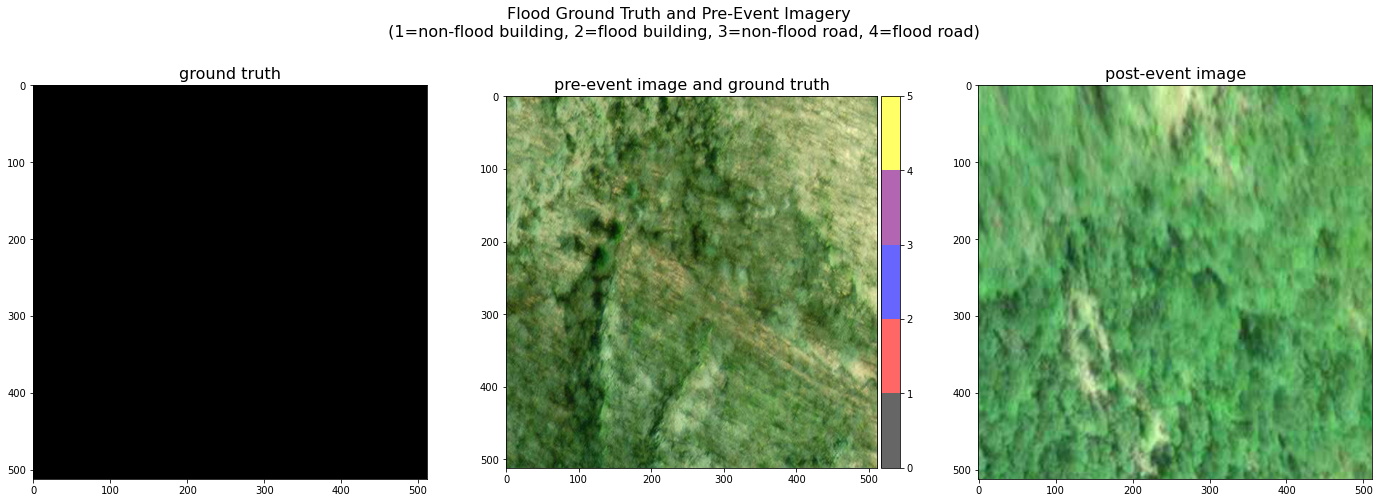

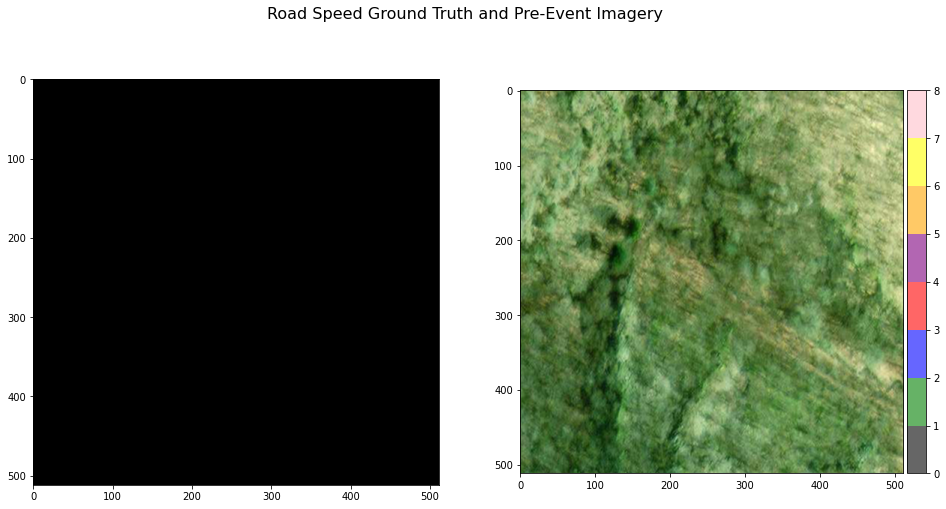

In [4]:

import numpy as np
import torch

n_to_visualize = 2 # number of batches to visualize
input_csv = "areas_of_interest/sn8_data_val.csv"


dataset = SN8Dataset(input_csv,
                     data_to_load=["preimg","postimg", "building", "road", "roadspeed", "flood"],
                     img_size=(1300,1300),
                     crop=(512, 512))
batch_size=1

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

for i, data in enumerate(dataloader):
    preimg, postimg, building, road, roadspeed, flood = data # data from here is shape (batch_size, channels, height, width)
    # preimg, postimg are shape=(batch_size, 3, 1024, 1024)
    # building labels are shape=(batch_size, 1, 1024, 1024)
    # road labels are shape=(batch_size, 1, 1024, 1024)
    # roadspeed labels are shape=(batch_size, 8, 1024, 1024)
    # flood labels are shape=(batch_size, 4, 1024, 1024)
    # print(preimg)
    preimg = preimg.cpu().numpy()[0]
    postimg = postimg.cpu().numpy()[0]
    flood = flood.cpu().numpy()[0]
    building = building.cpu().numpy()[0]
    road = road.cpu().numpy()[0]
    roadspeed = roadspeed.cpu().numpy()[0]

    flood_shape = flood.shape # (4, 1024, 1024).
    tempfld = np.zeros(shape=(flood_shape[0]+1,flood_shape[1],flood_shape[2]))
    tempfld[1:5] = flood
    flood = tempfld
    flood = np.argmax(flood, axis=0)

    roadspeed_shape = roadspeed.shape
    tempspeed = np.zeros(shape=(roadspeed_shape[0]+1,roadspeed_shape[1],roadspeed_shape[2]))
    tempspeed[1:] = roadspeed
    roadspeed = tempspeed
    roadspeed = np.argmax(roadspeed, axis=0)

    print("filename: ", dataset.get_image_filename(i))
    #print("pre-event image")
    #viz_rgb_image(preimg)
    #print("post-event image")
    #viz_rgb_image(postimg)
    viz_flood_mask(flood, preimg, postimg)
    viz_roadspeed_mask(roadspeed, preimg)

    if i == n_to_visualize-1:
        break